In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
import time
import pandas as pd


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_dir = 'C:\\Users\\ardo\\Documents\\semai\\dataset\\ripeness\\ripeness_v7.2'
print(data_dir)

C:\Users\ardo\Documents\semai\dataset\ripeness\ripeness_v7.2


In [3]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 593 files belonging to 4 classes.
Using 475 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 593 files belonging to 4 classes.
Using 118 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['belum matang', 'jankos', 'lewat matang', 'matang']


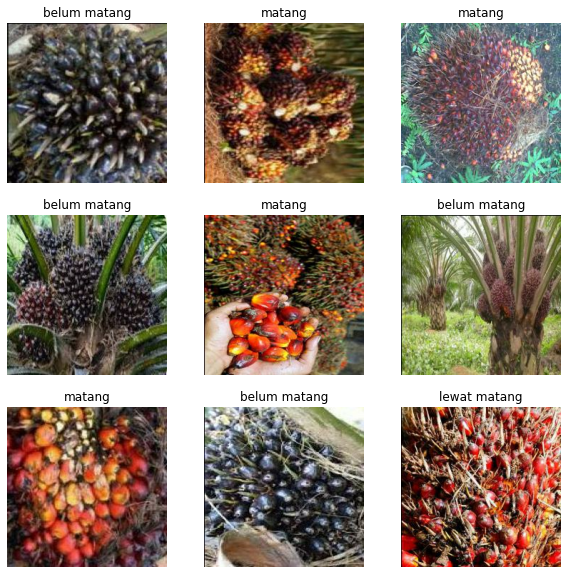

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [8]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [9]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

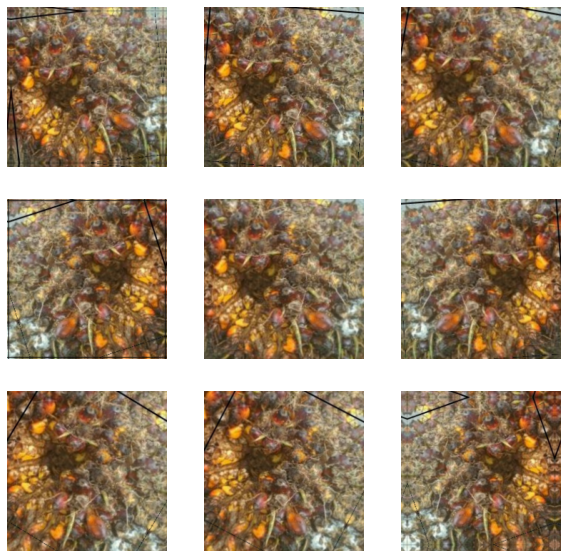

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [11]:
num_classes = 4

model = Sequential([
  data_augmentation,
  normalization_layer,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)       

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 6
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/6
15/15 [==============================] - 2s 113ms/step - loss: 1.5534 - accuracy: 0.5200 - val_loss: 0.8505 - val_accuracy: 0.6780
Epoch 2/6
15/15 [==============================] - 1s 73ms/step - loss: 0.8434 - accuracy: 0.7011 - val_loss: 0.7987 - val_accuracy: 0.6864
Epoch 3/6
15/15 [==============================] - 1s 70ms/step - loss: 0.7490 - accuracy: 0.6968 - val_loss: 0.6272 - val_accuracy: 0.7119
Epoch 4/6
15/15 [==============================] - 1s 72ms/step - loss: 0.6622 - accuracy: 0.7221 - val_loss: 0.5891 - val_accuracy: 0.7458
Epoch 5/6
15/15 [==============================] - 1s 72ms/step - loss: 0.6015 - accuracy: 0.7389 - val_loss: 0.5328 - val_accuracy: 0.7542
Epoch 6/6
15/15 [==============================] - 1s 71ms/step - loss: 0.5972 - accuracy: 0.7579 - val_loss: 0.5026 - val_accuracy: 0.7881


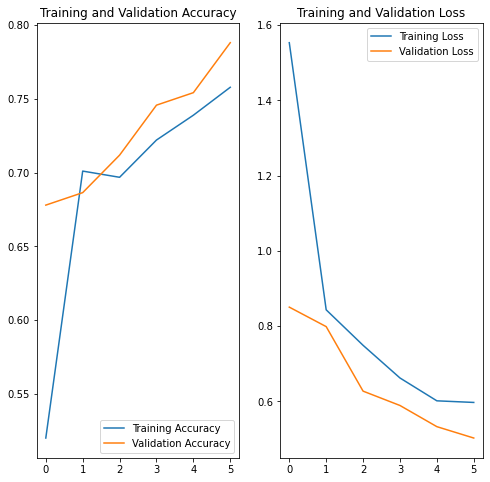

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

[[ 1.2268324  -0.9249207   0.3515497  -0.08152436]]
['belum matang', 'jankos', 'lewat matang', 'matang']
[0.555 0.064 0.231 0.15 ]
This image most likely belongs to belum matang with a 55.5 percent confidence.


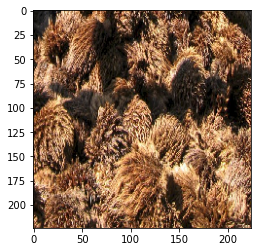

In [14]:
tandan_url = "https://akacn.ac.id/wp-content/uploads/2020/11/tandon-kosong-1.png"
tandan_loc = "C:\\Users\\ardo\\Documents\\personal\\dev\\notebook\\test_ripe_0604\\tandan_kos.jpg"
tandan_path = tf.keras.utils.get_file(tandan_loc, origin=tandan_url)

img = keras.preprocessing.image.load_img(
    tandan_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(predictions)
print(class_names)
print(np.round(score, 3))

print(
    "This image most likely belongs to {} with a {:.1f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

plt.imshow(img)

In [15]:
mobilenet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(mobilenet_url,
                                   input_shape=(img_height, img_width, 3))

feature_extractor.trainable = False

In [17]:
num_classes = 4

model = Sequential([
  data_augmentation,
  normalization_layer,
  feature_extractor,
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes),
  layers.ReLU()
])

model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_5 (Dense)              (None, 256)               327936    
_________________________________________________________________
dropout_2 (Dropout

In [18]:
early_stop_cuy = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=30, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop_cuy]
)

Epoch 1/100
15/15 [==============================] - 2s 162ms/step - loss: 0.9926 - accuracy: 0.6168 - val_loss: 0.6201 - val_accuracy: 0.7458
Epoch 2/100
15/15 [==============================] - 1s 93ms/step - loss: 0.7155 - accuracy: 0.7537 - val_loss: 0.4658 - val_accuracy: 0.8305
Epoch 3/100
15/15 [==============================] - 1s 91ms/step - loss: 0.4779 - accuracy: 0.8189 - val_loss: 0.3975 - val_accuracy: 0.8305
Epoch 4/100
15/15 [==============================] - 1s 91ms/step - loss: 0.3819 - accuracy: 0.8674 - val_loss: 0.3389 - val_accuracy: 0.8898
Epoch 5/100
15/15 [==============================] - 1s 91ms/step - loss: 0.3220 - accuracy: 0.9116 - val_loss: 0.2350 - val_accuracy: 0.9068
Epoch 6/100
15/15 [==============================] - 1s 90ms/step - loss: 0.2474 - accuracy: 0.9032 - val_loss: 0.2357 - val_accuracy: 0.9153
Epoch 7/100
15/15 [==============================] - 1s 90ms/step - loss: 0.2307 - accuracy: 0.9179 - val_loss: 0.2370 - val_accuracy: 0.9237
Epoch

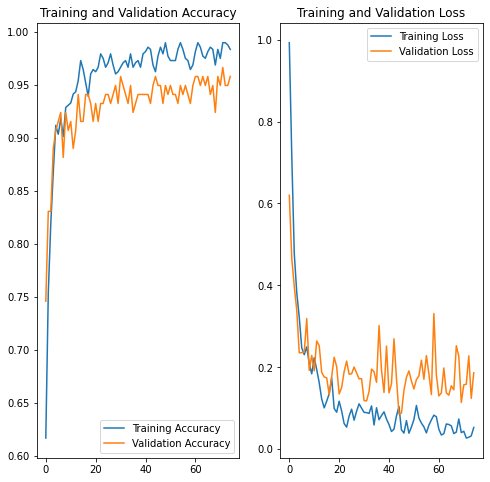

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(75)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

[[0.        1.3581232 9.628879  1.9428653]]
['belum matang', 'jankos', 'lewat matang', 'matang']
[0.    0.    0.999 0.   ]
This image most likely belongs to lewat matang with a 99.9 percent confidence.


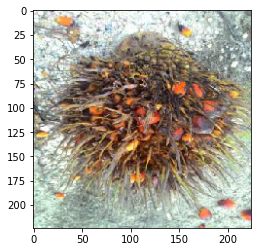

In [20]:
tandan_url = "https://docplayer.info/docs-images/70/62137124/images/31-0.jpg"
tandan_loc = "C:\\Users\\ardo\\Documents\\personal\\dev\\notebook\\test_ripe_0604\\tandan_lewat.jpg"
tandan_path = tf.keras.utils.get_file(tandan_loc, origin=tandan_url)

test_img = "C:\\Users\\ardo\\Documents\\semai\\dataset\\ripeness\\ripeness_v7.1\\belum matang\\4_jpg.rf.6da018ee5194f730fa76294e2ea00131.jpg"

img = keras.preprocessing.image.load_img(
    tandan_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(predictions)
print(class_names)
print(np.round(score, 3))

print(
    "This image most likely belongs to {} with a {:.1f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

plt.imshow(img)

In [22]:
timename = time.strftime("%Y%m%d%H%M%S")
saved_model_path = "ripeness-" + timename + ".h5" # or you can simply use 'my_model.h5'
model.save(saved_model_path) #save your model

In [23]:
# to reload your model if no snippet keras layer e.g MobileNetV2
#model = keras.models.load_model(saved_model_path)

model = keras.models.load_model(saved_model_path, custom_objects={'KerasLayer':hub.KerasLayer})
#model = keras.models.load_model('ripeness-20210406165324.h5', custom_objects={'KerasLayer':hub.KerasLayer})
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_5 (Dense)              (None, 256)               327936    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 4)                

In [24]:
# Get images and labels batch from validation dataset generator
val_image_batch, val_label_batch = next(iter(val_ds))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

# Get predictions for images batch
tf_model_predictions = model.predict(val_image_batch)
score = tf.nn.softmax(tf_model_predictions)
print("Prediction results shape:", score.shape)
score = np.round(score, 4)
# >> Prediction results shape: (32, 5)

# Convert prediction results to Pandas dataframe, for better visualization
tf_pred_dataframe = pd.DataFrame(score)
tf_pred_dataframe.columns = class_names

tf_pred_dataframe.head()


Validation batch shape: (32, 224, 224, 3)
Prediction results shape: (32, 4)


,belum matang,jankos,lewat matang,matang
0,0.0,0.9996,0.0004,0.0
1,0.0,0.0000,1.0000,0.0
2,1.0,0.0000,0.0000,0.0
3,0.0,0.0000,0.0000,1.0
4,0.0,0.0000,0.0000,1.0


In [25]:
tf_pred_dataframe_ori = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe_ori.columns = class_names

tf_pred_dataframe_ori.head()

,belum matang,jankos,lewat matang,matang
0,0.000000,10.359496,2.449699,0.000000
1,0.000000,2.798995,14.642978,2.654449
2,13.018651,0.000000,1.904888,0.000000
3,0.135129,0.000000,3.127995,15.271702
4,1.498485,0.000000,1.853229,13.968584


['jankos' 'lewat matang' 'belum matang' 'matang' 'matang' 'belum matang'
 'matang' 'belum matang' 'belum matang' 'matang' 'matang' 'lewat matang'
 'matang' 'lewat matang' 'belum matang' 'matang' 'belum matang' 'matang'
 'belum matang' 'lewat matang' 'matang' 'belum matang' 'matang'
 'lewat matang' 'matang' 'lewat matang' 'belum matang' 'matang' 'jankos'
 'belum matang' 'matang' 'belum matang']
Labels:            [1 2 0 3 3 0 3 0 0 3 3 2 3 2 0 3 0 3 0 2 3 0 3 3 3 2 0 3 1 0 3 0]
Predicted labels:  [1 2 0 3 3 0 3 0 0 3 3 2 3 2 0 3 0 3 0 2 3 0 3 2 3 2 0 3 1 0 3 0]


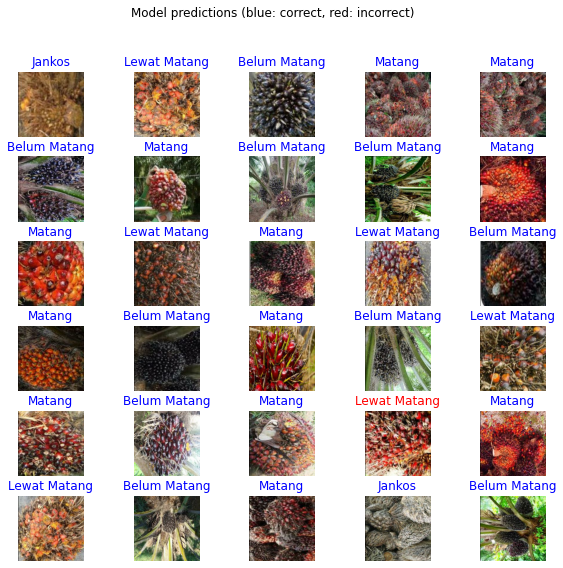

In [26]:
image_batch = val_image_batch.numpy()
label_batch = val_label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)

predicted_class_names = np.array(class_names)[predicted_ids]

print(predicted_class_names)
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n].astype('uint8'))
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [27]:
timename = time.strftime("%Y%m%d%H%M%S")
tflite_path = "ripeness-" + timename + ".tflite"
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(tflite_path, 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: C:\Users\ardo\AppData\Local\Temp\tmpgqw3r75y\assets


INFO:tensorflow:Assets written to: C:\Users\ardo\AppData\Local\Temp\tmpgqw3r75y\assets


In [28]:
timename = time.strftime("%Y%m%d%H%M%S")
tflite_q_path = "ripeness-q-" + timename + ".tflite"
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_q_model = converter.convert()
with open(tflite_q_path, 'wb') as f:
  f.write(tflite_q_model)

INFO:tensorflow:Assets written to: C:\Users\ardo\AppData\Local\Temp\tmpm1417czx\assets


INFO:tensorflow:Assets written to: C:\Users\ardo\AppData\Local\Temp\tmpm1417czx\assets


In [29]:
tflite_interpreter = tf.lite.Interpreter(model_path=tflite_path)
#tflite_interpreter = tf.lite.Interpreter(model_path='ripeness-20210406165419.tflite')

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

print("\n\nAfter Conversion:\n\n")

tflite_interpreter.resize_tensor_input(input_details[0]['index'], (32, 224, 224, 3))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (32, 5))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("shape:", input_details[0]['shape'])
print("\n== Output details ==")
print("shape:", output_details[0]['shape'])

== Input details ==
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
shape: [1 4]
type: <class 'numpy.float32'>


After Conversion:


== Input details ==
shape: [ 32 224 224   3]

== Output details ==
shape: [32  4]


In [30]:
# Set batch of images into input tensor
tflite_interpreter.set_tensor(input_details[0]['index'], val_image_batch)
# Run inference
tflite_interpreter.invoke()
# Get prediction results
tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])

score_tflite = tf.nn.softmax(tflite_model_predictions)
print("Prediction results shape:", score_tflite.shape)
score_tflite = np.round(score_tflite, 4)

# Convert prediction results to Pandas dataframe, for better visualization
tflite_pred_dataframe = pd.DataFrame(score_tflite)
tflite_pred_dataframe.columns = class_names

tflite_pred_dataframe.head()

Prediction results shape: (32, 4)


,belum matang,jankos,lewat matang,matang
0,0.0,0.9996,0.0004,0.0
1,0.0,0.0000,1.0000,0.0
2,1.0,0.0000,0.0000,0.0
3,0.0,0.0000,0.0000,1.0
4,0.0,0.0000,0.0000,1.0


In [31]:
tflite_pred_dataframe_ori = pd.DataFrame(tflite_model_predictions)
tflite_pred_dataframe_ori.columns = class_names

tflite_pred_dataframe_ori.head()

,belum matang,jankos,lewat matang,matang
0,0.000000,10.359487,2.449696,0.000000
1,0.000000,2.799006,14.642981,2.654430
2,13.018654,0.000000,1.904884,0.000000
3,0.135128,0.000000,3.127990,15.271716
4,1.498482,0.000000,1.853233,13.968567


In [32]:
tflite_q_interpreter = tf.lite.Interpreter(model_path=tflite_q_path)
#tflite_q_interpreter = tf.lite.Interpreter(model_path='ripeness-q-20210406165441.tflite')

input_q_details = tflite_q_interpreter.get_input_details()
output_q_details = tflite_q_interpreter.get_output_details()

print("== Input details ==")
print("shape:", input_q_details[0]['shape'])
print("type:", input_q_details[0]['dtype'])
print("\n== Output details ==")
print("shape:", output_q_details[0]['shape'])
print("type:", output_q_details[0]['dtype'])

print("\n\nAfter Conversion:\n\n")

tflite_q_interpreter.resize_tensor_input(input_q_details[0]['index'], (32, 224, 224, 3))
tflite_q_interpreter.resize_tensor_input(output_q_details[0]['index'], (32, 5))
tflite_q_interpreter.allocate_tensors()

input_q_details = tflite_q_interpreter.get_input_details()
output_q_details = tflite_q_interpreter.get_output_details()

print("== Input details ==")
print("shape:", input_q_details[0]['shape'])
print("\n== Output details ==")
print("shape:", output_q_details[0]['shape'])

== Input details ==
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
shape: [1 4]
type: <class 'numpy.float32'>


After Conversion:


== Input details ==
shape: [ 32 224 224   3]

== Output details ==
shape: [32  4]


In [33]:
# Set batch of images into input tensor
tflite_q_interpreter.set_tensor(input_q_details[0]['index'], val_image_batch)
# Run inference
tflite_q_interpreter.invoke()
# Get prediction results
tflite_q_model_predictions = tflite_q_interpreter.get_tensor(output_q_details[0]['index'])
score_tflite_q = tf.nn.softmax(tflite_q_model_predictions)
print("Prediction results shape:", score_tflite_q.shape)
score_tflite_q = np.round(score_tflite_q, 4)


# Convert prediction results to Pandas dataframe, for better visualization
tflite_q_pred_dataframe = pd.DataFrame(score_tflite_q)
tflite_q_pred_dataframe.columns = class_names

tflite_q_pred_dataframe.head()

Prediction results shape: (32, 4)


,belum matang,jankos,lewat matang,matang
0,0.8615,0.0176,0.0030,0.1179
1,0.0005,0.0224,0.9567,0.0203
2,0.9998,0.0001,0.0000,0.0000
3,0.0000,0.0000,0.0000,1.0000
4,0.0000,0.0000,0.0000,1.0000


In [34]:
tflite_q_pred_dataframe_ori = pd.DataFrame(tflite_q_model_predictions)
tflite_q_pred_dataframe_ori.columns = class_names

tflite_q_pred_dataframe_ori.head()

,belum matang,jankos,lewat matang,matang
0,5.670170,1.779319,0.000000,3.681221
1,0.000000,3.888339,7.640701,3.789961
2,11.170475,2.121035,0.629696,0.000000
3,0.663010,0.000000,2.740333,16.628540
4,0.315157,0.000000,1.475040,13.729517


In [35]:
tflite_pred_dataframe.head()

,belum matang,jankos,lewat matang,matang
0,0.0,0.9996,0.0004,0.0
1,0.0,0.0000,1.0000,0.0
2,1.0,0.0000,0.0000,0.0
3,0.0,0.0000,0.0000,1.0
4,0.0,0.0000,0.0000,1.0


In [36]:
tflite_pred_dataframe_ori.head()

,belum matang,jankos,lewat matang,matang
0,0.000000,10.359487,2.449696,0.000000
1,0.000000,2.799006,14.642981,2.654430
2,13.018654,0.000000,1.904884,0.000000
3,0.135128,0.000000,3.127990,15.271716
4,1.498482,0.000000,1.853233,13.968567


In [37]:
tf_pred_dataframe.head()

,belum matang,jankos,lewat matang,matang
0,0.0,0.9996,0.0004,0.0
1,0.0,0.0000,1.0000,0.0
2,1.0,0.0000,0.0000,0.0
3,0.0,0.0000,0.0000,1.0
4,0.0,0.0000,0.0000,1.0


In [38]:
tf_pred_dataframe_ori.head()

,belum matang,jankos,lewat matang,matang
0,0.000000,10.359496,2.449699,0.000000
1,0.000000,2.798995,14.642978,2.654449
2,13.018651,0.000000,1.904888,0.000000
3,0.135129,0.000000,3.127995,15.271702
4,1.498485,0.000000,1.853229,13.968584


In [38]:
def converttostr(input_seq, seperator):
   # Join all the strings in list
   final_str = seperator.join(input_seq)
   return final_str

labels = converttostr(class_names, '\n')
with open('labels.txt', 'w') as f:
    f.write(labels)